In [220]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter

df = pd.read_csv('online_retail_II.csv')
#df.head()

df = df.rename(columns={'Customer ID': 'customer_id'})

df = df.dropna(subset=['customer_id'])
df["customer_id"] = df["customer_id"].astype(int)

In [221]:
#Noticed purchases of outlier quantites (ex. >70000) that were entirely returned, and would greatly skew data if kept

qty_threshold = df["Quantity"].quantile(0.9995)
suspicious_df = df[df["Quantity"] > qty_threshold]


indices_to_remove = []

for index, transaction in suspicious_df.iterrows():
    #Find transaction with same customer_id, StockCode, and exact negative Quantity (likely a return/refund, etc.)
    matching_returns = df[
        (df['customer_id'] == transaction['customer_id']) &
        (df['StockCode'] == transaction['StockCode']) &
        (df['Quantity'] == -transaction['Quantity']) 
    ]
    
    if not matching_returns.empty:
        print(f"Purchase {transaction['Invoice']} (Qty: {transaction['Quantity']}) has a matching return")
        indices_to_remove.append(index)
        indices_to_remove.extend(matching_returns.index.tolist())
    else:
        print(f"Purchase {transaction['Invoice']} (Qty: {transaction['Quantity']}) has no matching return")

df_cleaned = df[~df.index.isin(indices_to_remove)].copy()

Purchase 490018 (Qty: 4320) has no matching return
Purchase 490018 (Qty: 5184) has no matching return
Purchase 490018 (Qty: 4008) has no matching return
Purchase 490018 (Qty: 4008) has no matching return
Purchase 490785 (Qty: 936) has no matching return
Purchase 491133 (Qty: 1500) has no matching return
Purchase 491212 (Qty: 1002) has no matching return
Purchase 491440 (Qty: 1080) has no matching return
Purchase 491812 (Qty: 960) has no matching return
Purchase 491812 (Qty: 864) has no matching return
Purchase 492185 (Qty: 3000) has no matching return
Purchase 493722 (Qty: 1440) has no matching return
Purchase 493722 (Qty: 1080) has no matching return
Purchase 493799 (Qty: 832) has no matching return
Purchase 495194 (Qty: 6012) has no matching return
Purchase 495194 (Qty: 866) has no matching return
Purchase 495194 (Qty: 6144) has no matching return
Purchase 495194 (Qty: 2040) has no matching return
Purchase 495194 (Qty: 2520) has no matching return
Purchase 495194 (Qty: 3888) has no m

In [222]:
df = df_cleaned.copy()
#df = df.sort_values(by='Quantity', ascending=False)
#print(df.head(10))

df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df["Revenue"] = df["Quantity"] * df["Price"]

In [ ]:
min_date = df['InvoiceDate'].min()
max_date = df['InvoiceDate'].max()
duration = max_date - min_date
observation_end = max_date
#print(duration)
#25% of duration is roughly 180 days, made this holdout period

t_holdout_days = 180

calibration_days = duration.days - 180
calibration_end_date = min_date + timedelta(days=calibration_days)

In [ ]:
print(f"Calibration Period: {min_date} to {calibration_end_date}")
print(f"Holdout Period: {calibration_end_date} to {observation_end}")

Calibration Period: 2009-12-01 07:45:00 to 2011-06-12 07:45:00
Holdout Period: 2011-06-12 07:45:00 to 2011-12-09 12:50:00


In [225]:
df_calibration = df[df['InvoiceDate'] <= calibration_end_date].copy()

In [226]:
from lifetimes.utils import summary_data_from_transaction_data

summary_calibration = summary_data_from_transaction_data(
    df_calibration,
    customer_id_col='customer_id',
    datetime_col='InvoiceDate',
    monetary_value_col='Revenue',
    observation_period_end=calibration_end_date
)

In [227]:
summary_calibration.columns.to_list()

['frequency', 'recency', 'T', 'monetary_value']

In [229]:
#fit beta geometric model
bgf_cal = BetaGeoFitter(penalizer_coef=0.001)
bgf_cal.fit(
    summary_calibration['frequency'],
    summary_calibration['recency'],
    summary_calibration['T']
)


summary_calibration['expected_purchases'] = bgf_cal.predict(
    t_holdout_days,  
    summary_calibration['frequency'],
    summary_calibration['recency'],
    summary_calibration['T']
)

summary_calibration['probability_alive'] = bgf_cal.conditional_probability_alive(
    summary_calibration['frequency'],
    summary_calibration['recency'],
    summary_calibration['T']
)

print(f"Fitted BG/NBD on {len(summary_calibration)} customers")

Fitted BG/NBD on 4976 customers


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

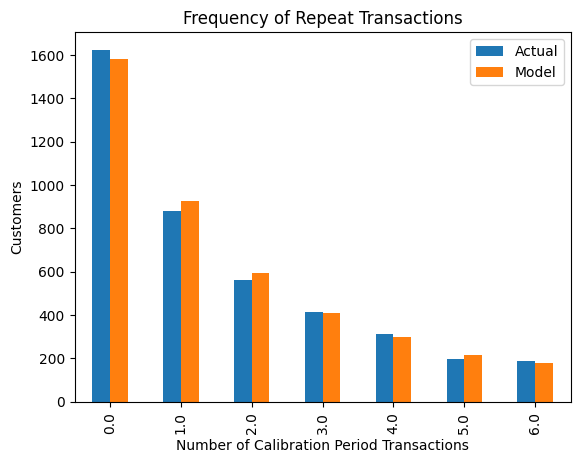

In [230]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf_cal)

In [231]:
#Only use repeat customers for gamma gamma model
repeat_cal = summary_calibration[summary_calibration["frequency"] > 0].copy()

ggf_cal = GammaGammaFitter(penalizer_coef=0.01)
ggf_cal.fit(
    repeat_cal['frequency'],  # Use correct column names!
    repeat_cal['monetary_value']
)

print(f"Fitted Gamma-Gamma on {len(repeat_cal)} repeat customers")


summary_calibration["expected_avg_monetary_value"] = np.nan

#Use gamma gamma predictions for repeat customers
summary_calibration.loc[summary_calibration['frequency'] > 0, "expected_avg_monetary_value"] = ggf_cal.conditional_expected_average_profit(
        repeat_cal['frequency'],  # Use repeat_cal data
        repeat_cal['monetary_value']
    )

repeat_cal_mean = summary_calibration.loc[summary_calibration['frequency'] > 0, "expected_avg_monetary_value"].mean()
print(f"Population average: ${repeat_cal_mean:.2f}")

#fill one time customers with population mean
summary_calibration["expected_avg_monetary_value"].fillna(repeat_cal_mean, inplace=True)


Fitted Gamma-Gamma on 3351 repeat customers
Population average: $443.11


In [232]:
#rough CLV prediction using expected purchases and expected avg monetary value

summary_calibration['predicted_clv'] = (
    summary_calibration['expected_purchases'] * 
    summary_calibration['expected_avg_monetary_value']
)

print(f"\nPredicted CLV stats:")
print(summary_calibration['predicted_clv'].describe())


Predicted CLV stats:
count      4976.000000
mean        784.808903
std        3190.429225
min           0.005783
25%         154.575869
50%         296.757257
75%         666.604601
max      127115.892721
Name: predicted_clv, dtype: float64


In [233]:
#prepare holdout
df_holdout = df[(df['InvoiceDate'] > calibration_end_date) & (df['Quantity'] > 0)].copy()

In [234]:
# Actual holdout data to compare predictions to

clv_holdout = (
    df_holdout
    .groupby('customer_id')['Revenue']
    .sum()
    .rename('actual_clv')
)

purchases_holdout = (
    df_holdout
    .groupby('customer_id')['Invoice']
    .nunique() 
    .rename('transactions_holdout')
)

summary_calibration = summary_calibration.join(clv_holdout, how='left')
summary_calibration['actual_clv'] = summary_calibration['actual_clv'].fillna(0)

summary_calibration = summary_calibration.join(purchases_holdout, how='left')
summary_calibration['transactions_holdout'] = summary_calibration['transactions_holdout'].fillna(0)
summary_calibration['monetary_value_holdout'] = summary_calibration['actual_clv']/summary_calibration['transactions_holdout']

print(f"\nCustomers active in holdout: {(summary_calibration['transactions_holdout'] > 0).sum()}")


Customers active in holdout: 2577


In [235]:
summary_calibration['monetary_value_holdout'].fillna(0, inplace=True)

In [236]:
summary_calibration.head(10)

,frequency,recency,T,monetary_value,expected_purchases,probability_alive,expected_avg_monetary_value,predicted_clv,actual_clv,transactions_holdout,monetary_value_holdout
customer_id,,,,,,,,,,,
12346,6.0,196.0,545.0,47.143333,0.380883,0.195894,49.199720,18.739361,0.00,0.0,0.000000
12347,4.0,221.0,224.0,729.435000,2.777691,0.978559,763.976574,2122.090672,2104.05,3.0,701.350000
12348,3.0,190.0,258.0,495.746667,1.879268,0.939234,527.952345,992.164045,310.00,1.0,310.000000
12349,2.0,182.0,409.0,801.310000,0.817453,0.818256,880.663853,719.901228,1757.55,1.0,1757.550000
12350,0.0,0.0,130.0,0.000000,0.599818,1.000000,443.108921,265.784624,0.00,0.0,0.000000
12351,0.0,0.0,195.0,0.000000,0.453592,1.000000,443.108921,200.990628,0.00,0.0,0.000000
12352,5.0,130.0,212.0,352.372000,3.196163,0.889782,365.993210,1169.773991,944.23,3.0,314.743333
12353,1.0,204.0,228.0,89.000000,0.929184,0.926819,112.477648,104.512385,0.00,0.0,0.000000
12354,0.0,0.0,52.0,0.000000,0.981079,1.000000,443.108921,434.725024,0.00,0.0,0.000000


In [237]:
#customers with highest predicted clv
summary_calibration.sort_values('predicted_clv', ascending=False).head(10)

,frequency,recency,T,monetary_value,expected_purchases,probability_alive,expected_avg_monetary_value,predicted_clv,actual_clv,transactions_holdout,monetary_value_holdout
customer_id,,,,,,,,,,,
18102,50.0,555.0,558.0,8780.154800,14.426544,0.997719,8811.250666,127115.892721,167527.67,43.0,3895.992326
14646,65.0,546.0,557.0,5520.328923,18.686404,0.995571,5535.376841,103436.286308,164070.10,46.0,3566.741304
14156,92.0,552.0,558.0,2612.666196,26.381084,0.997615,2617.715054,69058.161592,72514.28,36.0,2014.285556
14911,172.0,555.0,558.0,1132.579186,49.212890,0.998799,1133.760944,55795.652520,100435.38,135.0,743.965778
13694,68.0,552.0,555.0,2340.528824,19.653371,0.998164,2346.657920,46119.738655,33812.96,23.0,1470.128696
17450,13.0,246.0,258.0,5059.781538,7.366171,0.988781,5129.525331,37784.961315,138790.53,32.0,4337.204062
17511,36.0,531.0,557.0,3255.081389,10.358381,0.988275,3271.179433,33884.122194,55311.98,16.0,3456.998750
15061,55.0,554.0,558.0,2023.459273,15.849332,0.997675,2030.023615,32174.517508,23253.52,18.0,1291.862222
16684,26.0,527.0,552.0,4016.001154,7.605890,0.989794,4043.520037,30754.567470,41577.62,15.0,2771.841333


In [140]:
summary_calibration['predicted_clv_log'] = np.log1p(summary_calibration['predicted_clv'])
summary_calibration['actual_clv_log'] = np.log1p(summary_calibration['actual_clv'])

In [238]:
# Create bins for Probability Alive
summary_calibration['alive_bin'] = pd.cut(summary_calibration['probability_alive'], bins=5)

churn_eval = summary_calibration.groupby('alive_bin')['transactions_holdout'].apply(lambda x: (x > 0).mean())
print(churn_eval)

alive_bin
(-0.000997, 0.2]    0.200000
(0.2, 0.4]          0.322581
(0.4, 0.6]          0.289941
(0.6, 0.8]          0.402863
(0.8, 1.0]          0.545842
Name: transactions_holdout, dtype: float64


In [244]:
def model_evaluation(df, actual_col, predicted_col):

    from scipy.stats import spearmanr
    from sklearn.metrics import mean_absolute_error, root_mean_squared_error
    
    y_true = df[actual_col]
    y_pred = df[predicted_col]
    
    print(f"MODEL EVALUATION: {predicted_col}")
   
    #aggregate clv

    total_actual = y_true.sum()
    total_predicted = y_pred.sum()
    aggregate_error = ((total_predicted - total_actual) / total_actual * 100)

    print(f"\nAGGREGATE PERFORMANCE:")
    print(f"\nTotal Actual: ${total_actual:,.2f}")
    print(f"\nTotal Predicted: ${total_predicted:,.2f}")
    print(f"\nError: {aggregate_error:+.1f}%")
    
    #ranking ability
    spearman = spearmanr(y_true, y_pred).correlation
    print(f"\nRANKING ABILITY:")
    print(f"\nSpearman Correlation: {spearman:.3f}")

    #decile analysis
    df_temp = df[[actual_col, predicted_col]].copy()
    df_temp['predicted_decile'] = pd.qcut(
        df_temp[predicted_col],
        q=10,
        labels=range(1, 11),
        duplicates='drop'
    )

    decile_analysis = df_temp.groupby('predicted_decile').agg({
        actual_col: ['sum', 'mean', 'count'],
        predicted_col: ['sum', 'mean']
    }).round(2)

    print(f"\nDECILE ANALYSIS:")
    print(decile_analysis)

    top_decile_actual = df_temp[df_temp['predicted_decile'] == 10][actual_col].sum()
    top_decile_pct = (top_decile_actual / total_actual) * 100
    print(f"\nTop decile captures {top_decile_pct:.1f}% of actual revenue")

    #Lift
    df_sorted = df_temp.sort_values(predicted_col, ascending=False)
    top_20_pct = df_sorted.head(int(len(df_sorted) * 0.2))
    top_20_revenue = top_20_pct[actual_col].sum()
    top_20_lift = (top_20_revenue / total_actual) / 0.2

    print(f"\n4. LIFT ANALYSIS:")
    print(f"\nTop 20% predicted customers contain {(top_20_revenue/total_actual)*100:.1f}% of revenue")
    print(f"\nLift: {top_20_lift:.2f}x better than random")


    #model evaluation metrics
    mae = mean_absolute_error(df_temp[actual_col], df_temp[predicted_col])
    rmse = root_mean_squared_error(df_temp[actual_col], df_temp[predicted_col])
    print(f"\nMAE: ${mae:,.2f}")
    print(f"\nRMSE: {rmse:,.2f}")


In [245]:
model_evaluation(summary_calibration, 'actual_clv', 'predicted_clv')

MODEL EVALUATION: predicted_clv

AGGREGATE PERFORMANCE:

Total Actual: $4,401,571.71

Total Predicted: $3,905,209.10

Error: -11.3%

RANKING ABILITY:

Spearman Correlation: 0.612

DECILE ANALYSIS:
                  actual_clv                predicted_clv         
                         sum     mean count           sum     mean
predicted_decile                                                  
1                   34131.36    68.26   500      34789.00    69.58
2                   39886.61    80.42   496      55461.28   111.82
3                   84165.05   166.99   504      76828.47   152.44
4                   85010.10   173.14   491      92644.98   188.69
5                  130410.03   261.87   498     126581.99   254.18
6                  146650.42   295.07   497     172305.87   346.69
7                  206061.20   414.61   497     234873.88   472.58
8                  305954.54   614.37   498     334630.43   671.95
9                  586534.15  1180.15   497     548085.97  1102.79

XGBoost Model below

In [248]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Create feature matrix from calibration data
def create_customer_feature_matrix(summary_calibration):
  
    features = pd.DataFrame(index=summary_calibration.index)
    
    features['frequency'] = summary_calibration['frequency']
    features['recency'] = summary_calibration['recency']
    features['T'] = summary_calibration['T']
    features['monetary_value'] = summary_calibration['monetary_value']
    features['avg_time_between_purchases'] = summary_calibration['T'] / (summary_calibration['frequency'] + 1)
    features['purchase_rate'] = summary_calibration['frequency'] / (summary_calibration['T'] + 1)
    features['is_repeat_customer'] = (summary_calibration['frequency'] > 0).astype(int)
    features['time_since_last_purchase'] = summary_calibration['T'] - summary_calibration['recency']
    features['probability_alive'] = summary_calibration['probability_alive']
    features['expected_avg_monetary_bgf'] = summary_calibration['expected_avg_monetary_value']
    features = features.fillna(0)
    
    return features

X_cal = create_customer_feature_matrix(summary_calibration)

#target
y = summary_calibration['actual_clv'] 

In [249]:
#Validation split for hyperparameter tuning

X_train, X_val, y_train, y_val = train_test_split(
    X_cal, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Training set: {len(X_train)} customers")
print(f"Validation set: {len(X_val)} customers")



xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    eval_metric='rmse'
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)]
)


y_pred_xgb = xgb_model.predict(X_cal)


summary_calibration['predicted_clv_xgb'] = y_pred_xgb


Training set: 3980 customers
Validation set: 996 customers
[0]	validation_0-rmse:5457.59619
[1]	validation_0-rmse:5145.45059
[2]	validation_0-rmse:4849.69496
[3]	validation_0-rmse:4733.91615
[4]	validation_0-rmse:4550.85081
[5]	validation_0-rmse:4293.09581
[6]	validation_0-rmse:4221.40630
[7]	validation_0-rmse:4142.77018
[8]	validation_0-rmse:4004.75344
[9]	validation_0-rmse:3826.19384
[10]	validation_0-rmse:3639.48014
[11]	validation_0-rmse:3613.75948
[12]	validation_0-rmse:3579.09813
[13]	validation_0-rmse:3572.16190
[14]	validation_0-rmse:3429.25374
[15]	validation_0-rmse:3431.13074
[16]	validation_0-rmse:3303.33828
[17]	validation_0-rmse:3224.08345
[18]	validation_0-rmse:3224.86994
[19]	validation_0-rmse:3117.05834
[20]	validation_0-rmse:3061.70601
[21]	validation_0-rmse:3056.95146
[22]	validation_0-rmse:2969.49346
[23]	validation_0-rmse:2971.47349
[24]	validation_0-rmse:2927.07620
[25]	validation_0-rmse:2848.49223
[26]	validation_0-rmse:2778.37895
[27]	validation_0-rmse:2715.77267

In [250]:
summary_calibration.head()

,frequency,recency,T,monetary_value,expected_purchases,probability_alive,expected_avg_monetary_value,predicted_clv,actual_clv,transactions_holdout,monetary_value_holdout,alive_bin,predicted_clv_xgb
customer_id,,,,,,,,,,,,,
12346,6.0,196.0,545.0,47.143333,0.380883,0.195894,49.199720,18.739361,0.00,0.0,0.00,"(-0.000997, 0.2]",38.734795
12347,4.0,221.0,224.0,729.435000,2.777691,0.978559,763.976574,2122.090672,2104.05,3.0,701.35,"(0.8, 1.0]",1882.457764
12348,3.0,190.0,258.0,495.746667,1.879268,0.939234,527.952345,992.164045,310.00,1.0,310.00,"(0.8, 1.0]",685.864929
12349,2.0,182.0,409.0,801.310000,0.817453,0.818256,880.663853,719.901228,1757.55,1.0,1757.55,"(0.8, 1.0]",587.769287
12350,0.0,0.0,130.0,0.000000,0.599818,1.000000,443.108921,265.784624,0.00,0.0,0.00,"(0.8, 1.0]",157.794998


In [253]:
#Clip values so the minimum is 0
summary_calibration['predicted_clv_xgb'] = summary_calibration['predicted_clv_xgb'].clip(lower=0)

In [254]:
importance_scores = xgb_model.get_booster().get_score(importance_type='gain')

#Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': importance_scores.keys(),
    'Importance': importance_scores.values()
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                      Feature   Importance
3              monetary_value  372081312.0
7           probability_alive  329412864.0
5               purchase_rate  252806176.0
0                   frequency  214242464.0
6    time_since_last_purchase  194848976.0
8   expected_avg_monetary_bgf  188945664.0
4  avg_time_between_purchases  125376432.0
2                           T   73563256.0
1                     recency   20000038.0


In [255]:
model_evaluation(summary_calibration, 'actual_clv', 'predicted_clv_xgb')

MODEL EVALUATION: predicted_clv_xgb

AGGREGATE PERFORMANCE:

Total Actual: $4,401,571.71

Total Predicted: $4,402,603.50

Error: +0.0%

RANKING ABILITY:

Spearman Correlation: 0.635

DECILE ANALYSIS:
                  actual_clv                predicted_clv_xgb             
                         sum     mean count               sum         mean
predicted_decile                                                          
1                   29106.86    54.00   539      3.233766e+04    60.000000
2                   34478.00    75.44   457      4.293548e+04    93.949997
3                   78941.13   147.28   536      6.280732e+04   117.180000
4                   69603.41   151.64   459      7.079902e+04   154.250000
5                  111698.00   224.74   497      1.128300e+05   227.020004
6                  162829.86   325.66   500      1.674366e+05   334.869995
7                  202305.47   408.70   495      2.159144e+05   436.190002
8                  306103.56   614.67   498      3

Bipartite Graph

In [256]:
#print df calibration start, end, time range

print(df_calibration['InvoiceDate'].min())
print(df_calibration['InvoiceDate'].max())
print(df_calibration['InvoiceDate'].max() - df_calibration['InvoiceDate'].min())


2009-12-01 07:45:00
2011-06-10 16:47:00
556 days 09:02:00


In [258]:
import networkx as nx
from networkx.algorithms import bipartite

df_graph = df_calibration.copy()

B = nx.Graph()
B.add_nodes_from(df_graph['customer_id'].unique(), bipartite=0)
B.add_nodes_from(df_graph['StockCode'].unique(), bipartite=1)

edges = df_graph.groupby(['customer_id', 'StockCode'])['Revenue'].sum().reset_index()
B.add_weighted_edges_from(zip(edges['customer_id'], edges['StockCode'], edges['Revenue']))

In [259]:
customer_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]

#degree: # of unique products
degree_dict = dict(B.degree(customer_nodes))

#weighted degree: total spend
weighted_degree = dict(B.degree(customer_nodes, weight='weight'))

#HHI (Product Concentration): does the customer buy 100 things once, or 1 thing 100 times?
def calculate_hhi(G, node):
    weights = [data['weight'] for _, _, data in G.edges(node, data=True)]
    total = sum(weights)
    return sum([(w/total)**2 for w in weights]) if total > 0 else 0

hhi_dict = {n: calculate_hhi(B, n) for n in customer_nodes}

In [260]:
#average neighbor degree: Are they buying popular products?
avg_neighbor_degree = nx.average_neighbor_degree(B, nodes=customer_nodes)

In [261]:
# Product-Customer Adjacency Matrix
A = bipartite.biadjacency_matrix(B, customer_nodes, df_graph['StockCode'].unique())

# Customer-Customer Similarity (Dot product of matrix)
# Entry (i, j) = how many shared products between customer i and j
C_sim = A @ A.T 

# Feature: Average 'loyalty' or 'value' of people who buy similar things
avg_sim_value = np.array(C_sim.mean(axis=1)).flatten()

In [262]:
# Measure the "importance" of a node based on its connections
pagerank_dict = nx.pagerank(B, weight='weight')

In [170]:
eigen_dict = nx.eigenvector_centrality_numpy(B, weight='weight')


In [263]:
X_cal['pagerank'] = X_cal.index.map(pagerank_dict)
X_cal['centrality'] = X_cal.index.map(eigen_dict)
X_cal['unique_products'] = X_cal.index.map(degree_dict)
X_cal['product_concentration'] = X_cal.index.map(hhi_dict)
X_cal['avg_neighbor_popularity'] = X_cal.index.map(avg_neighbor_degree)
X_cal['behavioral_similarity_index'] = avg_sim_value # Aligned by index

In [264]:
X_train, X_val, y_train, y_val = train_test_split(
    X_cal, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Training set: {len(X_train)} customers")
print(f"Validation set: {len(X_val)} customers")


xgb_graph = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    eval_metric='rmse'
)

xgb_graph.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)]
)


#Make predictions on full dataset
y_pred_xgb_graph = xgb_graph.predict(X_cal)

summary_calibration['predicted_clv_xgb_graph'] = y_pred_xgb_graph

Training set: 3980 customers
Validation set: 996 customers
[0]	validation_0-rmse:5454.26046
[1]	validation_0-rmse:5065.02066
[2]	validation_0-rmse:4758.73881
[3]	validation_0-rmse:4535.20668
[4]	validation_0-rmse:4372.12959
[5]	validation_0-rmse:4171.13318
[6]	validation_0-rmse:4114.81443
[7]	validation_0-rmse:4025.18656
[8]	validation_0-rmse:3854.74586
[9]	validation_0-rmse:3700.37081
[10]	validation_0-rmse:3650.90578
[11]	validation_0-rmse:3513.31974
[12]	validation_0-rmse:3510.34586
[13]	validation_0-rmse:3374.52694
[14]	validation_0-rmse:3327.99830
[15]	validation_0-rmse:3322.62498
[16]	validation_0-rmse:3211.86920
[17]	validation_0-rmse:3202.52301
[18]	validation_0-rmse:3176.23380
[19]	validation_0-rmse:3170.57087
[20]	validation_0-rmse:3165.76186
[21]	validation_0-rmse:3199.80433
[22]	validation_0-rmse:3210.21617
[23]	validation_0-rmse:3205.49084
[24]	validation_0-rmse:3199.78055
[25]	validation_0-rmse:3131.56838
[26]	validation_0-rmse:3071.81812
[27]	validation_0-rmse:3117.05121

In [265]:
model_evaluation(summary_calibration, 'actual_clv', 'predicted_clv_xgb_graph')

MODEL EVALUATION: predicted_clv_xgb_graph

AGGREGATE PERFORMANCE:

Total Actual: $4,401,571.71

Total Predicted: $4,400,995.50

Error: -0.0%

RANKING ABILITY:

Spearman Correlation: 0.698

DECILE ANALYSIS:
                  actual_clv                predicted_clv_xgb_graph  \
                         sum     mean count                     sum   
predicted_decile                                                      
1                    3651.51     6.25   584            8.330700e+03   
2                   10975.82    26.64   412            1.464948e+04   
3                   42095.49    84.53   498            4.365965e+04   
4                   88476.73   178.02   497            7.185802e+04   
5                   98304.12   197.80   497            1.107015e+05   
6                  140843.60   282.82   498            1.575328e+05   
7                  222665.65   448.02   497            2.343023e+05   
8                  328849.27   660.34   498            3.457372e+05   
9            

In [266]:
importance_scores_graph = xgb_graph.get_booster().get_score(importance_type='gain')

importance_df_graph = pd.DataFrame({
    'Feature': importance_scores_graph.keys(),
    'Importance': importance_scores_graph.values()
}).sort_values(by='Importance', ascending=False)

print(importance_df_graph)

                        Feature   Importance
10                   centrality  934466432.0
9                      pagerank  573871488.0
13      avg_neighbor_popularity  237384368.0
3                monetary_value  168706560.0
6      time_since_last_purchase  159524528.0
8     expected_avg_monetary_bgf   93433360.0
0                     frequency   91848000.0
12        product_concentration   65213872.0
7             probability_alive   61608076.0
14  behavioral_similarity_index   57900772.0
1                       recency   49764508.0
2                             T   46365320.0
11              unique_products   44764304.0
4    avg_time_between_purchases   30284370.0
5                 purchase_rate   18829054.0


Final Model

In [267]:
start_date = observation_end - timedelta(days=calibration_days)

df = df[(df['InvoiceDate'] > start_date) & (df['InvoiceDate'] <= observation_end)]

In [268]:
print(start_date)
print((observation_end - start_date).days)

2010-05-30 12:50:00
558


In [269]:
summary = summary_data_from_transaction_data(
    df,
    customer_id_col='customer_id',
    datetime_col='InvoiceDate',
    monetary_value_col='Revenue',
    observation_period_end=observation_end
)

In [270]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

summary['expected_purchases'] = bgf.predict(
    180,
    summary['frequency'],
    summary['recency'],
    summary['T']
)

summary['probability_alive'] = bgf.conditional_probability_alive(
    summary['frequency'],
    summary['recency'],
    summary['T']
)

summary['clv'] = np.nan

c:\Users\bulls\clv\venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [271]:
repeat = summary[summary['frequency'] > 0].copy()

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(repeat['frequency'], repeat['monetary_value'])

summary["expected_avg_monetary_value"] = np.nan

summary.loc[summary['frequency'] > 0, 'expected_avg_monetary_value'] = ggf.conditional_expected_average_profit(
    repeat['frequency'],
    repeat['monetary_value']
)

mean = summary.loc[summary['frequency'] > 0, "expected_avg_monetary_value"].mean()
summary["expected_avg_monetary_value"] = summary["expected_avg_monetary_value"].fillna(mean)

In [272]:
summary["expected_avg_monetary_value"].describe()

count     5372.000000
mean       442.478002
std        426.957586
min          5.668796
25%        266.954637
50%        442.478002
75%        442.478002
max      10117.060588
Name: expected_avg_monetary_value, dtype: float64

In [273]:
X = create_customer_feature_matrix(summary)

In [274]:
X.columns.to_list()

['frequency',
 'recency',
 'T',
 'monetary_value',
 'avg_time_between_purchases',
 'purchase_rate',
 'is_repeat_customer',
 'time_since_last_purchase',
 'probability_alive',
 'expected_avg_monetary_bgf']

In [275]:
df_graph = df.copy()


B = nx.Graph()
B.add_nodes_from(df_graph['customer_id'].unique(), bipartite=0)
B.add_nodes_from(df_graph['StockCode'].unique(), bipartite=1)


edges = df_graph.groupby(['customer_id', 'StockCode'])['Revenue'].sum().reset_index()
B.add_weighted_edges_from(zip(edges['customer_id'], edges['StockCode'], edges['Revenue']))

customer_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]

# Degree: How many unique products?
degree_dict = dict(B.degree(customer_nodes))


# Weighted Degree: Total spend captured in graph terms
weighted_degree = dict(B.degree(customer_nodes, weight='weight'))


# HHI (Product Concentration): Does the customer buy 100 things once, or 1 thing 100 times?
def calculate_hhi(G, node):
    weights = [data['weight'] for _, _, data in G.edges(node, data=True)]
    total = sum(weights)
    return sum([(w/total)**2 for w in weights]) if total > 0 else 0


hhi_dict = {n: calculate_hhi(B, n) for n in customer_nodes}

# Average neighbor degree: Are they buying popular products?
avg_neighbor_degree = nx.average_neighbor_degree(B, nodes=customer_nodes)

# Use the adjacency matrix for speed on 4.9k nodes
# Product-Customer Matrix
A = bipartite.biadjacency_matrix(B, customer_nodes, df_graph['StockCode'].unique())

# Customer-Customer Similarity (Dot product of matrix)
# Entry (i, j) = how many shared products between customer i and j
C_sim = A @ A.T

# Feature: Average 'loyalty' or 'value' of people who buy similar things
# This acts as a proxy for social/behavioral influence
avg_sim_value = np.array(C_sim.mean(axis=1)).flatten()

pagerank_dict = nx.pagerank(B, weight='weight')

eigen_dict = nx.eigenvector_centrality_numpy(B, weight='weight')

In [276]:
X['pagerank'] = X.index.map(pagerank_dict)
X['centrality'] = X.index.map(eigen_dict)
#X['community_id'] = X.index.map(communities)
X['unique_products'] = X.index.map(degree_dict)
X['product_concentration'] = X.index.map(hhi_dict)
X['avg_neighbor_popularity'] = X.index.map(avg_neighbor_degree)
X['behavioral_similarity_index'] = avg_sim_value
X.rename(columns={'expected_avg_monetary_value': 'expected_avg_monetary_bgf'}, inplace=True)


In [277]:
summary['pagerank'] = summary.index.map(pagerank_dict)
summary['centrality'] = summary.index.map(eigen_dict)
summary['unique_products'] = summary.index.map(degree_dict)
summary['product_concentration'] = summary.index.map(hhi_dict)
summary['avg_neighbor_popularity'] = summary.index.map(avg_neighbor_degree)
summary['behavioral_similarity_index'] = avg_sim_value

In [278]:

trained_feature_order = xgb_graph.get_booster().feature_names
X = X[trained_feature_order]
y_xgb_graph = xgb_graph.predict(X)
summary['clv'] = y_xgb_graph


In [279]:
#change customer id from index to column in summary
summary = summary.reset_index()
summary.columns

Index(['customer_id', 'frequency', 'recency', 'T', 'monetary_value',
       'expected_purchases', 'probability_alive', 'clv',
       'expected_avg_monetary_value', 'pagerank', 'centrality',
       'unique_products', 'product_concentration', 'avg_neighbor_popularity',
       'behavioral_similarity_index'],
      dtype='object')

In [280]:
#customer stats of top 5 predicted clv
summary.sort_values(by='clv', ascending=False).head(5)

,customer_id,frequency,recency,T,monetary_value,expected_purchases,probability_alive,clv,expected_avg_monetary_value,pagerank,centrality,unique_products,product_concentration,avg_neighbor_popularity,behavioral_similarity_index
2098,14646,71.0,553.0,554.0,5894.250282,20.790654,0.999211,122079.304688,5909.006503,0.011764,0.022893,874,0.005807,206.056064,366.793018
5210,18102,44.0,549.0,549.0,10076.351818,13.060278,0.998865,110095.875000,10117.060588,0.011029,0.700937,240,0.020725,196.120833,407.567809
4677,17511,41.0,553.0,555.0,3345.469024,12.062485,0.998606,108729.593750,3360.038069,0.003830,0.017461,561,0.007166,226.668449,5041.124748
3930,16684,27.0,546.0,550.0,4532.719630,8.069196,0.997780,93472.148438,4562.713103,0.003410,0.014339,177,0.013691,274.158192,9922.836181
1583,14088,13.0,411.0,421.0,3949.358462,5.029959,0.994865,88428.648438,4004.059917,0.001935,0.010024,436,0.004650,207.456422,10669.838665


In [283]:
summary['clv'] = summary['clv'].clip(lower=0)

print(f"Mean CLV: {summary['clv'].mean():.2f}")
print(f"Total CLV: {summary['clv'].sum():,.2f}")

Mean CLV: 939.70
Total CLV: 5,048,060.00


In [284]:
summary['clv'].describe()

count      5372.000000
mean        939.698425
std        4471.233887
min           0.000000
25%         131.286163
50%         296.774475
75%         754.281372
max      122079.304688
Name: clv, dtype: float64

In [289]:
summary['monetary_rank'] = summary['expected_avg_monetary_value'].rank(method='first')

summary['expected_monetary_value_segment'] = pd.qcut(
    summary['monetary_rank'],
    q=4,
    labels=['Low', 'Medium', 'High', 'Very High']
)

In [ ]:
summary['expected_frequency_segment'] = pd.qcut(
    summary['expected_purchases'],
    q=4,
    labels=['Low', 'Medium', 'High', 'Very High']
)

In [ ]:
#add each customer's data from last 6 months to the dataframe for comparison

clv_holdout = (
    df_holdout
    .groupby('customer_id')['Revenue']
    .sum()
    .reset_index()
    .rename(columns={'Revenue': 'clv_last_6_months'})
)

purchases_holdout = (
    df_holdout
    .groupby('customer_id')['Invoice']
    .nunique()
    .reset_index()
    .rename(columns={'Invoice': 'purchases_last_6_months'})
)


summary = summary.merge(clv_holdout, on='customer_id', how='left')
summary = summary.merge(purchases_holdout, on='customer_id', how='left')


summary[['clv_last_6_months', 'purchases_last_6_months']] = summary[['clv_last_6_months', 'purchases_last_6_months']].fillna(0)


summary['monetary_value_last_6_months'] = (
    summary['clv_last_6_months'] / 
    summary['purchases_last_6_months'].replace(0, np.nan)
).fillna(0)

In [295]:
summary.columns.to_list()

['customer_id',
 'frequency',
 'recency',
 'T',
 'monetary_value',
 'expected_purchases',
 'probability_alive',
 'clv',
 'expected_avg_monetary_value',
 'pagerank',
 'centrality',
 'unique_products',
 'product_concentration',
 'avg_neighbor_popularity',
 'behavioral_similarity_index',
 'stat_clv',
 'clv_gap',
 'monetary_rank',
 'expected_monetary_value_segment',
 'expected_frequency_segment',
 'clv_last_6_months_x',
 'purchases_last_6_months_x',
 'monetary_value_last_6_months',
 'clv_last_6_months_y',
 'purchases_last_6_months_y']

In [294]:
print(summary['customer_id', 'clv', 'clv_last_6_months', 'purchases_last_6_months'].head())

KeyError: ('customer_id', 'clv', 'clv_last_6_months', 'purchases_last_6_months')

In [210]:
#print clv, clv_last_6_months, transactions_last_6_months, monetary_value_last_6_months
summary[['customer_id','clv', 'clv_last_6_months', 'purchases_last_6_months', 'monetary_value_last_6_months']].head(50)

,customer_id,clv,clv_last_6_months,purchases_last_6_months,monetary_value_last_6_months
0,12346,59.914898,0.00,0.0,0.000000
1,12347,2296.415039,2104.05,3.0,701.350000
2,12348,536.183289,310.00,1.0,310.000000
3,12349,2717.323242,1757.55,1.0,1757.550000
4,12350,102.152740,0.00,0.0,0.000000
5,12351,51.993534,0.00,0.0,0.000000
6,12352,872.710144,944.23,3.0,314.743333
7,12353,44.793705,0.00,0.0,0.000000
8,12354,168.675919,0.00,0.0,0.000000
9,12355,120.592903,0.00,0.0,0.000000


In [211]:
performance_data = [
    {
        "Model": "bg/nbd",
        "Aggregate_Forecast": 3905209.10,
        "Aggregate_Error_Pct": -11.3,
        "Spearman_Rank": 0.612,
        "Top_Decile_Capture_Pct": 63.2,
        "Lift_Top_20_Pct": 3.83,
        "MAE": 827.82,
        "Complexity": "Baseline"
    },
    {
        "Model": "xgb",
        "Aggregate_Forecast": 4402603.50,
        "Aggregate_Error_Pct": 0.0,
        "Spearman_Rank": 0.635,
        "Top_Decile_Capture_Pct": 65.2,
        "Lift_Top_20_Pct": 3.87,
        "MAE": 584.50,
        "Complexity": "Intermediate"
    },
    {
        "Model": "xgb w/ graph features",
        "Aggregate_Forecast": 4391331.00,
        "Aggregate_Error_Pct": -0.2,
        "Spearman_Rank": 0.646,
        "Top_Decile_Capture_Pct": 65.8,
        "Lift_Top_20_Pct": 3.90,
        "MAE": 572.50,
        "Complexity": "Advanced"
    }
]

model_performance_df = pd.DataFrame(performance_data)

In [215]:
import sqlite3

# 1. Calculate Actuals from your holdout data (the last 6 months)
# Assuming 'df_holdout' contains your actual sales for that period
actual_revenue = df_holdout.groupby('customer_id')['Revenue'].sum().reset_index()
actual_revenue.columns = ['customer_id', 'actual_revenue']

# 2. Merge actuals with your predictions (summary table)
# Fill NaN with 0 for customers who didn't buy in the holdout period
temp2 = summary.copy()

comparison_df = temp2.merge(actual_revenue, on='customer_id', how='left')
comparison_df['actual_revenue'] = comparison_df['actual_revenue'].fillna(0)

# 3. Pre-calculate the Actual Pareto Curve
actual_pareto = comparison_df[['actual_revenue']].sort_values('actual_revenue', ascending=False)
actual_pareto['cum_perc_revenue'] = 100 * actual_pareto['actual_revenue'].cumsum() / actual_pareto['actual_revenue'].sum()
actual_pareto['cum_perc_customers'] = 100 * (np.arange(len(actual_pareto)) + 1) / len(actual_pareto)

# 4. Pre-calculate the Predicted Pareto Curve
pred_pareto = comparison_df[['clv']].sort_values('clv', ascending=False)
pred_pareto['cum_perc_revenue'] = 100 * pred_pareto['clv'].cumsum() / pred_pareto['clv'].sum()
pred_pareto['cum_perc_customers'] = 100 * (np.arange(len(pred_pareto)) + 1) / len(pred_pareto)

# Take 100 points from each for the app
pareto_comparison = pd.DataFrame({
    'perc_customers': actual_pareto['cum_perc_customers'].iloc[::len(actual_pareto)//100].values,
    'actual_revenue_cum': actual_pareto['cum_perc_revenue'].iloc[::len(actual_pareto)//100].values,
    'predicted_revenue_cum': pred_pareto['cum_perc_revenue'].iloc[::len(pred_pareto)//100].values
})

# Calculate Global Averages for Gauges
global_stats = pd.DataFrame([{
    'avg_clv': summary['clv'].mean(),
    'median_clv': summary['clv'].median(),
    'avg_prob_alive': summary['probability_alive'].mean(),
    'top_10_threshold': summary['clv'].quantile(0.9)
}])

In [216]:
# 1. Get unique StockCodes and their most frequent Description
product_table = df.groupby('StockCode')['Description'].agg(lambda x: x.value_counts().index[0]).reset_index()

# 2. Map the PageRank from your bipartite dictionary
# Note: pagerank_dict comes from nx.pagerank(B)
product_table['pagerank'] = product_table['StockCode'].map(lambda x: pagerank_dict.get(x, 0))

# 3. Normalize for visualization (0 to 1 scale)
if not product_table['pagerank'].empty:
    max_pr = product_table['pagerank'].max()
    min_pr = product_table['pagerank'].min()
    
    # Check to avoid division by zero if all pageranks are the same
    if max_pr - min_pr != 0:
        product_table['pagerank_norm'] = (product_table['pagerank'] - min_pr) / (max_pr - min_pr)
    else:
        product_table['pagerank_norm'] = 0.5 # Default middle value

In [217]:
product_table.head()

,StockCode,Description,pagerank,pagerank_norm
0,10002,INFLATABLE POLITICAL GLOBE,0.000136,0.016511
1,10080,GROOVY CACTUS INFLATABLE,0.000020,0.000619
2,10120,DOGGY RUBBER,0.000019,0.000494
3,10123C,HEARTS WRAPPING TAPE,0.000019,0.000438
4,10123G,ARMY CAMO WRAPPING TAPE,0.000021,0.000713


In [218]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,customer_id,Country,Revenue
216642,510429,37448,CERAMIC CAKE DESIGN SPOTTED MUG,2,2010-05-30 12:55:00,1.49,17618,United Kingdom,2.98
216643,510429,21231,SWEETHEART CERAMIC TRINKET BOX,3,2010-05-30 12:55:00,1.25,17618,United Kingdom,3.75
216644,510429,21232,STRAWBERRY CERAMIC TRINKET BOX,2,2010-05-30 12:55:00,1.25,17618,United Kingdom,2.50
216645,510429,22528,GARDENERS KNEELING PAD,4,2010-05-30 12:55:00,1.25,17618,United Kingdom,5.00
216646,510429,47566B,TEA TIME PARTY BUNTING,6,2010-05-30 12:55:00,4.65,17618,United Kingdom,27.90


In [219]:
# 1. Aggregate with the most recent date
customer_edges = df.groupby(['customer_id', 'StockCode']).agg({
    'Invoice': 'count',
    'Revenue': 'sum',
    'InvoiceDate': 'max'  # Captures the most recent transaction for this specific link
}).reset_index()

# 2. Rename columns for clarity
customer_edges.columns = [
    'customer_id', 'StockCode', 'purchase_count', 'total_spent', 'last_purchase_date'
]

# 3. Add Product PageRank from your pre-existing product_table
# This is more efficient than re-mapping from the dictionary
customer_edges = customer_edges.merge(
    product_table[['StockCode', 'pagerank', 'pagerank_norm']], 
    on='StockCode', 
    how='left'
)

In [ ]:
conn = sqlite3.connect('clv_app.db')

# 1. Customer Profiles
summary.to_sql('customer_profiles', conn, if_exists='replace', index=False)

# 2. Product Information
product_table.to_sql('products', conn, if_exists='replace', index=False)

# 3. Edges for Graph
customer_edges.to_sql('customer_edges', conn, if_exists='replace', index=False)

# 4. Global Metrics
pareto_comparison.to_sql('pareto_curve', conn, if_exists='replace', index=False)
global_stats.to_sql('global_stats', conn, if_exists='replace', index=False)

# 5. Raw Transactions (for the History tab)
df[['customer_id', 'InvoiceDate', 'StockCode', 'Description', 'Quantity', 'UnitPrice']].to_sql('transactions', conn, if_exists='replace', index=False)

#model evaluation metrics, importance dfs

# --- CRITICAL: Create Indexes ---
# This speeds up "WHERE CustomerID = 12345" queries from seconds to milliseconds
conn.execute('CREATE INDEX idx_cust_id ON customer_profiles (customer_id)')
conn.execute('CREATE INDEX idx_edge_cust ON customer_edges (customer_id)')
conn.execute('CREATE INDEX idx_trans_cust ON transactions ("customer_id")')
conn.execute('CREATE INDEX idx_prod_code ON products (StockCode)')

conn.close()